In [1]:
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning) 

/home/lars/temp/causal_inference/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dowhy.__version__

'0.12'

In [3]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

# Chapter 09



## Matching

### Read the data

In [4]:
earnings_data = pd.read_csv(r'./data/ml_earnings.csv')

In [5]:
earnings_data.shape

In [6]:
earnings_data.head()

,age,took_a_course,earnings
0,19,False,110579.0
1,28,False,142577.0
2,22,True,130520.0
3,25,True,142687.0
4,24,False,127832.0


In [7]:
earnings_data.groupby(['age', 'took_a_course']).mean()

earnings
age took_a_course               
19  False          111110.875000
    True           123488.000000
20  False          115227.142857
    True           125633.285714
21  False          117114.900000
    True           130155.000000
22  False          120226.363636
    True           131437.222222
23  False          124460.900000
    True           134654.333333
24  False          126878.583333
    True           137564.250000
25  False          130812.800000
    True           142715.000000
26  False          134004.250000
    True           144552.800000
27  False          139035.600000
    True           148744.333333
28  False          141580.000000
    True           152485.333333
29  False          145248.600000
    True           152694.000000
30  False          150333.750000
    True           159586.400000
31  False          152532.000000
    True           163592.000000
32  False          157515.200000
    True           169854.000000
33  False          162453.500000
    True           170020.000000
34  False          165694.200000
    True           178922.000000
35  False          172134.250000
    True           180404.500000
36  False          175240.666667
37  False          181514.000000
    True           187627.000000
38  False          185546.333333
39  False          187253.666667
41  False          201729.000000
    True           207676.000000
42  False          203029.000000
    True           214445.000000
43  False          210243.000000
45  True           233035.000000
48  False          239510.000000

In [8]:
# Compute naive estimate 
treatment_avg = earnings_data.query('took_a_course==1')['earnings'].mean()
cntrl_avg = earnings_data.query('took_a_course==0')['earnings'].mean()

treatment_avg - cntrl_avg

### Define the graph

In [9]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

In [10]:
# Instantiate the CausalModel 
model = CausalModel(
    data=earnings_data,
    treatment='took_a_course',
    outcome='earnings',
    graph=gml_string
)


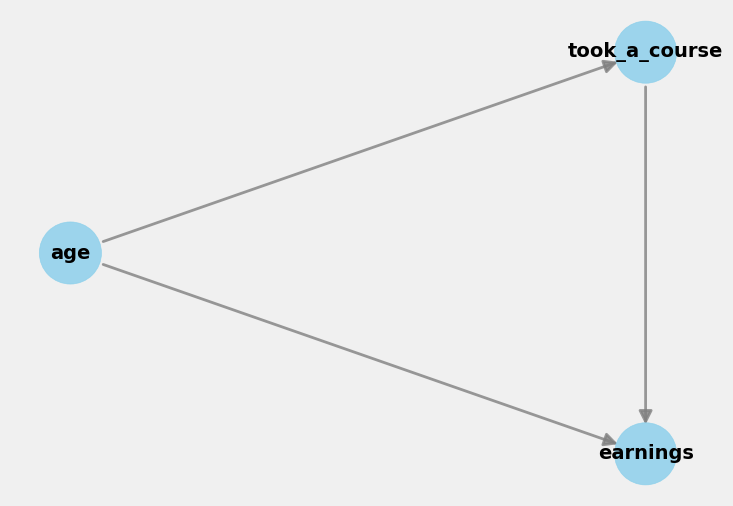

In [11]:
model.view_model()

### Get the estimand

In [12]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimate the effect

In [13]:
# Get estimate (Matching)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

In [14]:
estimate.value

In [15]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause')

In [16]:
print(refutation)

Refute: Add a random common cause
Estimated effect:10464.5
New effect:10335.505449999999
p value:0.6



## Inverse Probability Weighting (IPW)

In [17]:
pd.read_csv('data/ch_01_drug_data.csv')

gender = [1] * (24 + 56 + 17 + 25) + [0] * (3 + 39 + 6 +74)
clot = [1] * 24 + [0] * 56 + [1] * 17 + [0] * 25 + [1] * 3 + [0] * 39 + [1] * 6 + [0] * 74
drug = [0] * (24 + 56) + [1] * (17 + 25) + [0] * 42 + [1] * 80

drug_data = pd.DataFrame(dict(
    gender=gender,
    clot=clot,
    drug=drug
))

# Construct the graph (the graph is constant for all iterations)
nodes_drug = ['drug', 'clot', 'gender']
edges_drug = [
    ('drug', 'clot'),
    ('gender', 'drug'),
    ('gender', 'clot')
]

# Generate the GML graph
gml_string_drug = 'graph [directed 1\n'

for node in nodes_drug:
    gml_string_drug += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges_drug:
    gml_string_drug += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string_drug += ']'

# Instantiate the CausalModel
model_drug = CausalModel(
    data=drug_data,
    treatment='drug',
    outcome='clot',
    graph=gml_string_drug
)

# Identify effect
estimand_drug = model_drug.identify_effect()

# Get estimate (IPW weighting)
estimate_drug = model_drug.estimate_effect(
    identified_estimand=estimand_drug,
    method_name='backdoor.propensity_score_weighting',
    target_units='ate'
)

print(estimate_drug.value)

0.048119663707345744


In [18]:
# Get estimate (IPW weighting)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_weighting',
    target_units='ate'
)

In [19]:
estimate.value

In [20]:
(estimate.value - 10e3) / 10e3

## S-Learner: The Lone Ranger

In [21]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

### Read the data

In [22]:
# Train set
earnings_interaction_train = pd.read_csv(r'./data/ml_earnings_interaction_train.csv')

# Test set
earnings_interaction_test = pd.read_csv(r'./data/ml_earnings_interaction_test.csv')

In [23]:
earnings_interaction_train.shape, earnings_interaction_test.shape

In [24]:
# Train 
earnings_interaction_train.head()

,age,python_proficiency,took_a_course,earnings
0,23,0.632318,True,139267.0
1,20,0.602551,False,115569.0
2,21,0.518225,False,119142.0
3,25,0.945161,False,130291.0
4,30,0.636251,True,164209.0


In [25]:
# Test
earnings_interaction_test.head()

,age,python_proficiency,took_a_course,true_effect
0,30,0.223877,True,11120.0
1,23,0.394152,True,11970.0
2,37,0.214638,True,11073.0
3,21,0.869069,True,14345.0
4,41,0.833934,True,14169.0


### Define the graph

In [26]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'python_proficiency', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings'),
    ('python_proficiency', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

In [27]:
# Instantiate the CausalModel 
model = CausalModel(
    data=earnings_interaction_train,
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

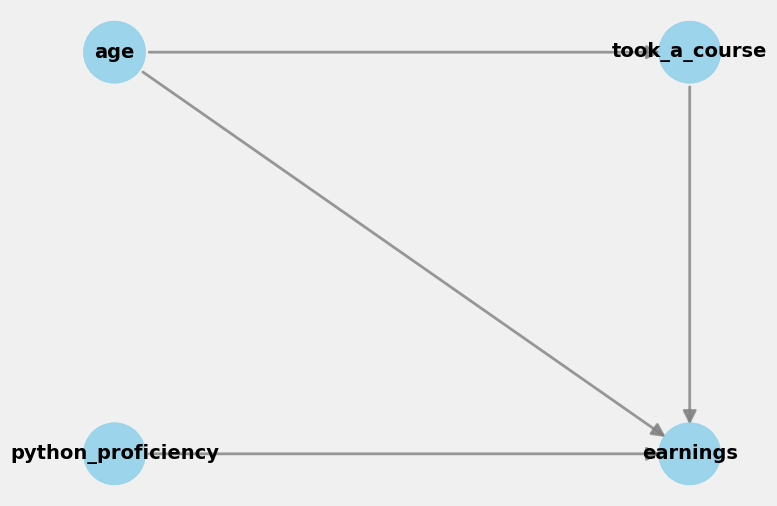

In [28]:
model.view_model()

### Get the estimand

In [29]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimate the effect

In [30]:
# Get estimate (S-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.SLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'overall_model': LGBMRegressor(
                n_estimators=500, 
                max_depth=10, 
                force_col_wise=True,  # Force column-wise computation
                verbose=-1  # Suppress detailed output
            )
        },
        'fit_params': {}
    }
)

In [31]:
estimate.cate_estimates.mean()

### Refute

In [32]:
# Refutation with the same settings carried over
refutation = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='random_common_cause'
)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instea

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instea

In [33]:
print(refutation)

Refute: Add a random common cause
Estimated effect:12547.068205674783
New effect:12545.579821584532
p value:0.9



In [34]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='placebo_treatment_refuter')

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instea

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instea

In [35]:
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:12547.068205674783
New effect:-18.79768667647177
p value:0.9



### Predict on test data

In [36]:
# Compute predictions
#effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))
effect_pred = estimate.estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [37]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

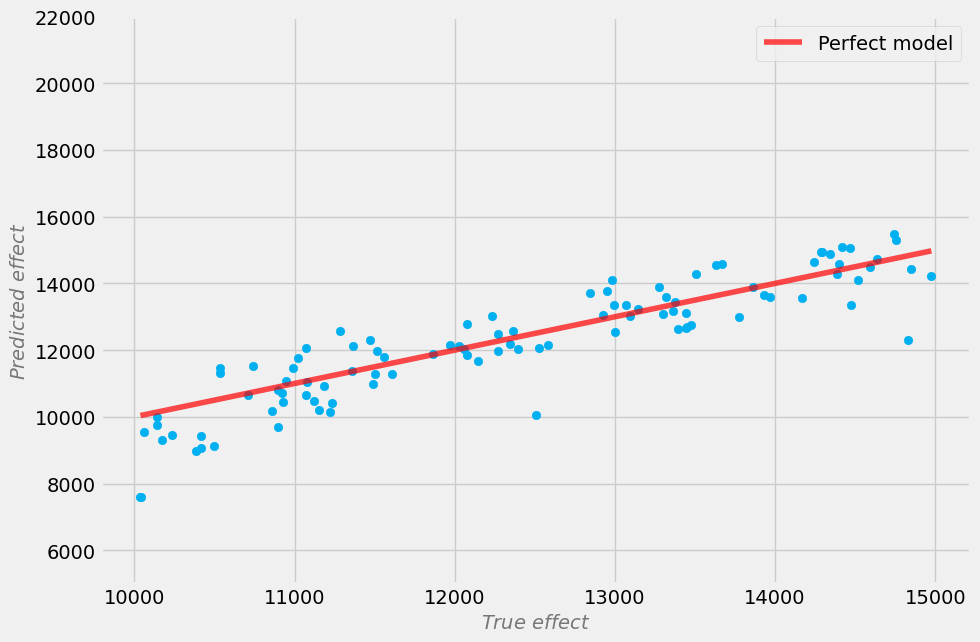

In [38]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### What happens when your dataset is small?

In [39]:
# Instantiate the CausalModel 
model_small = CausalModel(
    data=earnings_interaction_train.sample(100),
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

In [40]:
# Get estimate (S-Learner)
estimate = model_small.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.SLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'overall_model': LGBMRegressor(n_estimators=500, max_depth=10)
        },
        'fit_params': {}
    })

In [41]:
# Compute predictions
# effect_pred = model_small.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))
effect_pred = estimate.estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [42]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

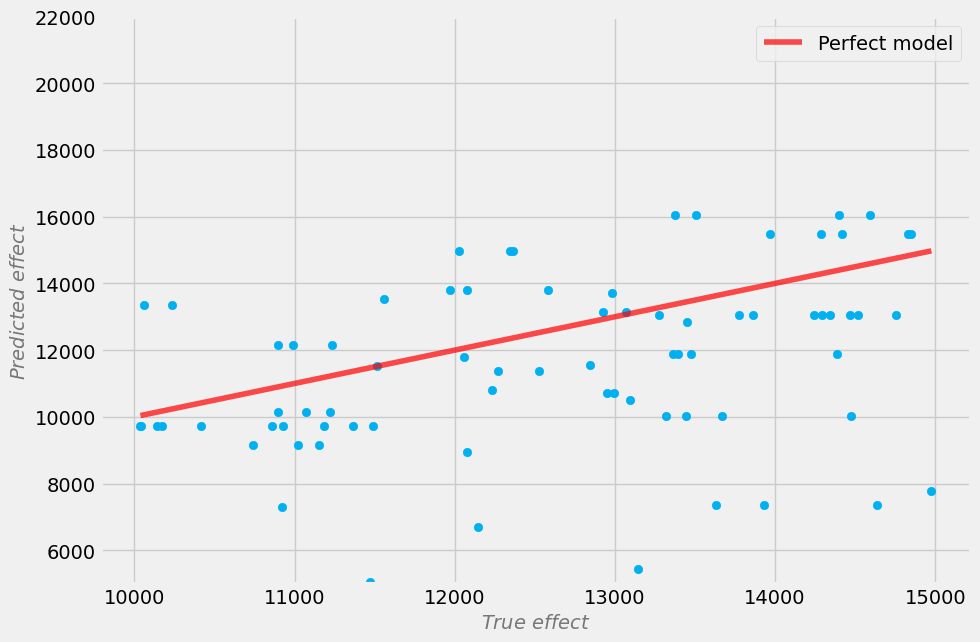

In [43]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

## T-Learner: Together We Can Do More

### Estimate the effect

In [44]:
# Get estimate (T-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.TLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(n_estimators=200, max_depth=10),
                LGBMRegressor(n_estimators=200, max_depth=10)
            ]
        },
        'fit_params': {}
    })

In [45]:
estimate.cate_estimates.mean()

### Predict on test data

In [46]:
# Compute predictions
#effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))
effect_pred = estimate.estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [47]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

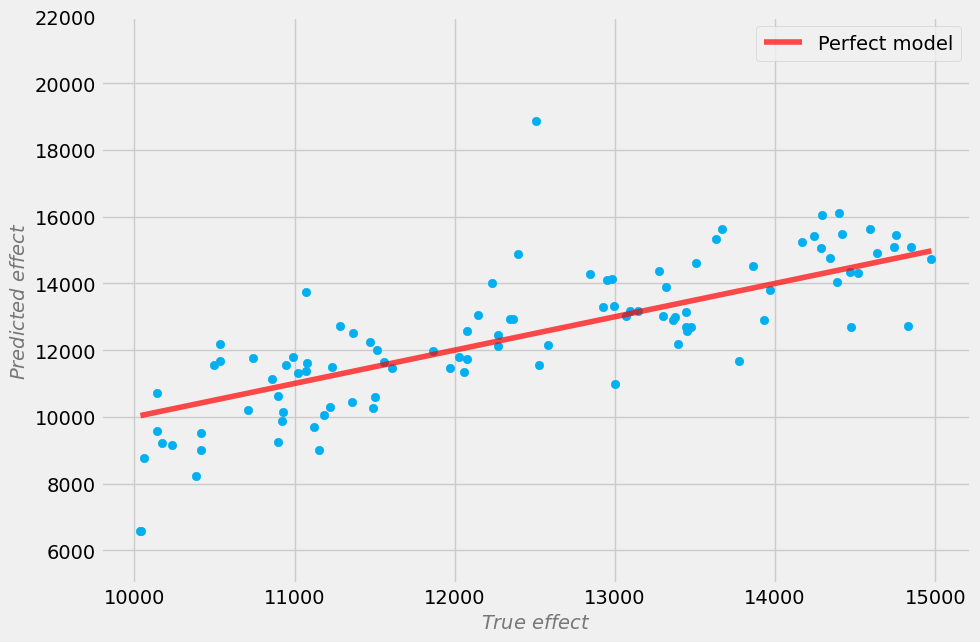

In [48]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

## X-Learner: A Step Further

### Estimate the effect

In [49]:
# Get estimate (X-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(n_estimators=50, max_depth=10),
                LGBMRegressor(n_estimators=50, max_depth=10)
            ],
            'cate_models': [
                LGBMRegressor(n_estimators=50, max_depth=10),
                LGBMRegressor(n_estimators=50, max_depth=10)
            ]
        },
        'fit_params': {},
    })

In [50]:
# X-Learner with just one specified model - equivalent to the cell above
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': LGBMRegressor(n_estimators=50, max_depth=10),
        },
        'fit_params': {},
    })

In [51]:
estimate.cate_estimates.mean()

### Predict on test data

In [52]:
# Compute predictions
#effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))
effect_pred = estimate.estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))
# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [53]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

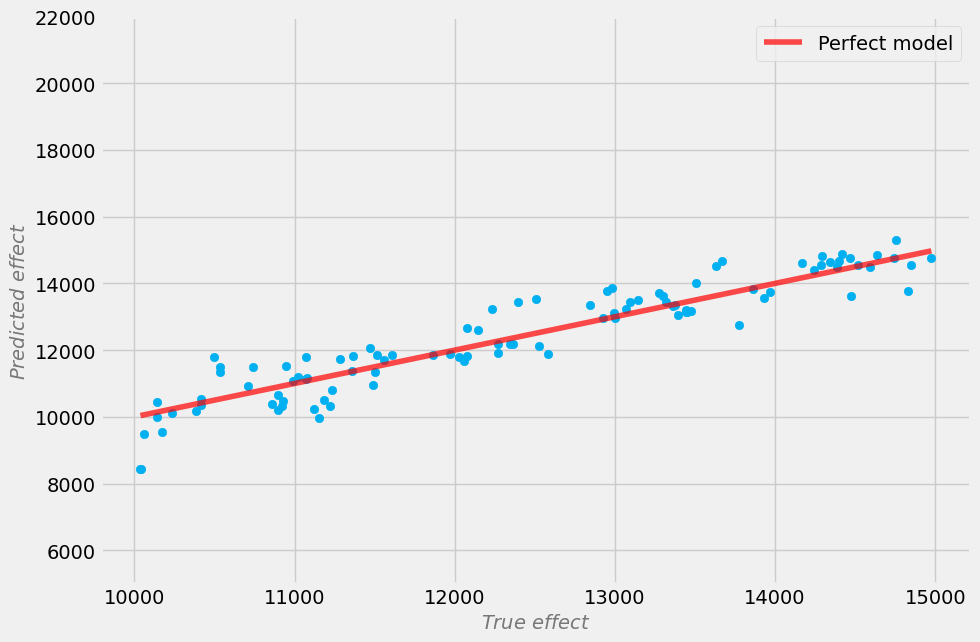

In [54]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### X-Learner on small data

In [55]:
# Get estimate (X-Learner)
estimate = model_small.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': LGBMRegressor(n_estimators=50, max_depth=10)
        },
        'fit_params': {}
    })

In [56]:
# Compute predictions
#effect_pred = model_small.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))
effect_pred = estimate.estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))
# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [57]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

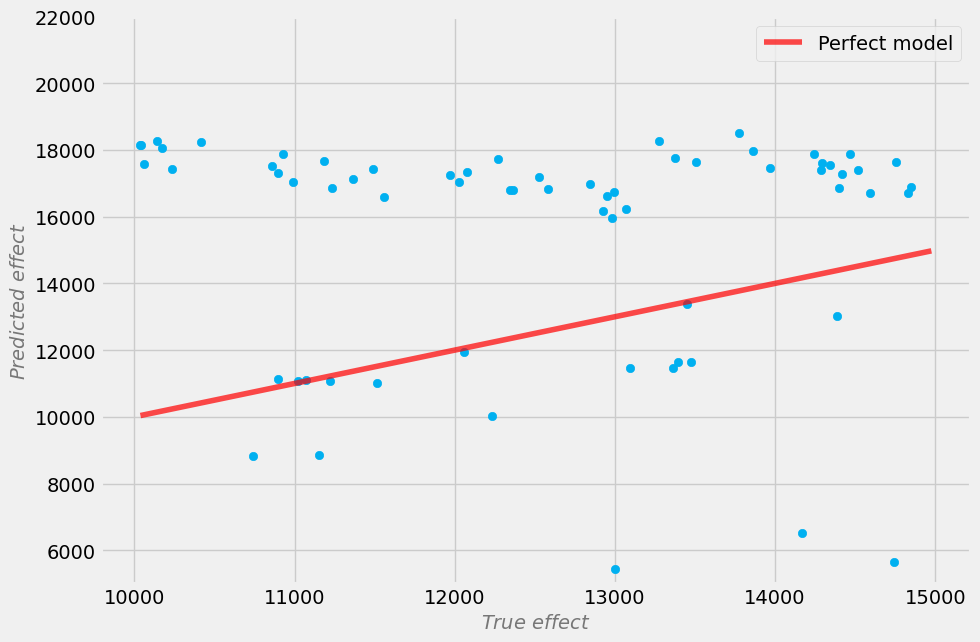

In [58]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

## Meta-Learners on experiental data (Kevin Hillstrom)

In [59]:
import json

# Read in the data
hillstrom_clean = pd.read_csv(r'./data/hillstrom_clean.csv')

# Read in labels mapping
with open(r'./data/hillstrom_clean_label_mapping.json', 'r') as f:
    hillstrom_labels_mapping = json.load(f)


In [60]:
hillstrom_clean.head()

,recency,history,mens,womens,newbie,visit,conversion,spend,zip_code__rural,zip_code__surburban,zip_code__urban,channel__multichannel,channel__phone,channel__web,treatment
0,10,142.44,1,0,0,0,0,0.0,0,1,0,0,1,0,1
1,6,329.08,1,1,1,0,0,0.0,1,0,0,0,0,1,0
2,7,180.65,0,1,1,0,0,0.0,0,1,0,0,0,1,1
3,9,675.83,1,0,1,0,0,0.0,1,0,0,0,0,1,2
4,2,45.34,1,0,0,0,0,0.0,0,0,1,0,0,1,1


In [61]:
hillstrom_clean.columns

Index(['recency', 'history', 'mens', 'womens', 'newbie', 'visit', 'conversion',
       'spend', 'zip_code__rural', 'zip_code__surburban', 'zip_code__urban',
       'channel__multichannel', 'channel__phone', 'channel__web', 'treatment'],
      dtype='object')

## Doubly Robust Methods: Let’s Get More!

### Estimate the effect

In [62]:
# Get estimate (Doubly robust)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dr.DRLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'model_propensity': LogisticRegression(),
            'model_regression': LGBMRegressor(n_estimators=1000, max_depth=10)
        },
        'fit_params': {}
    })

In [63]:
estimate.cate_estimates.mean()

### Predict on test data

In [64]:
# Compute predictions
#effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))
effect_pred = estimate.estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [65]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

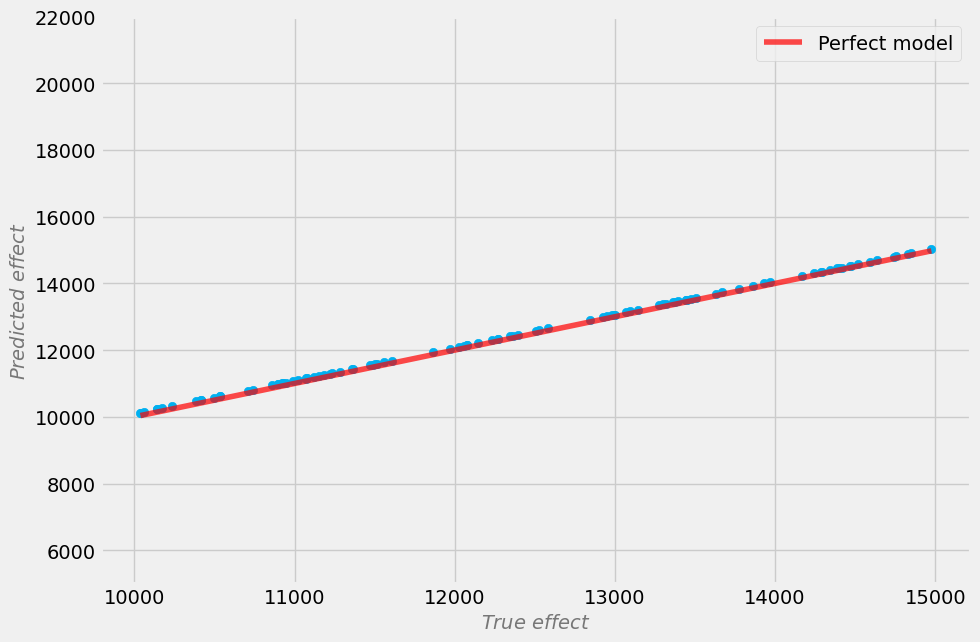

In [66]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

## If Machine Learning is Cool, How About Double Machine Learning?

### Estimate the effect

In [67]:
# Get estimate (DML)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=500, max_depth=10),
            'model_t': LGBMRegressor(n_estimators=500, max_depth=10),
        },
        'fit_params': {}
    })

In [68]:
estimate.cate_estimates.mean()

### Predict on test data

In [69]:
# Compute predictions
#effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))
effect_pred = estimate.estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [70]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

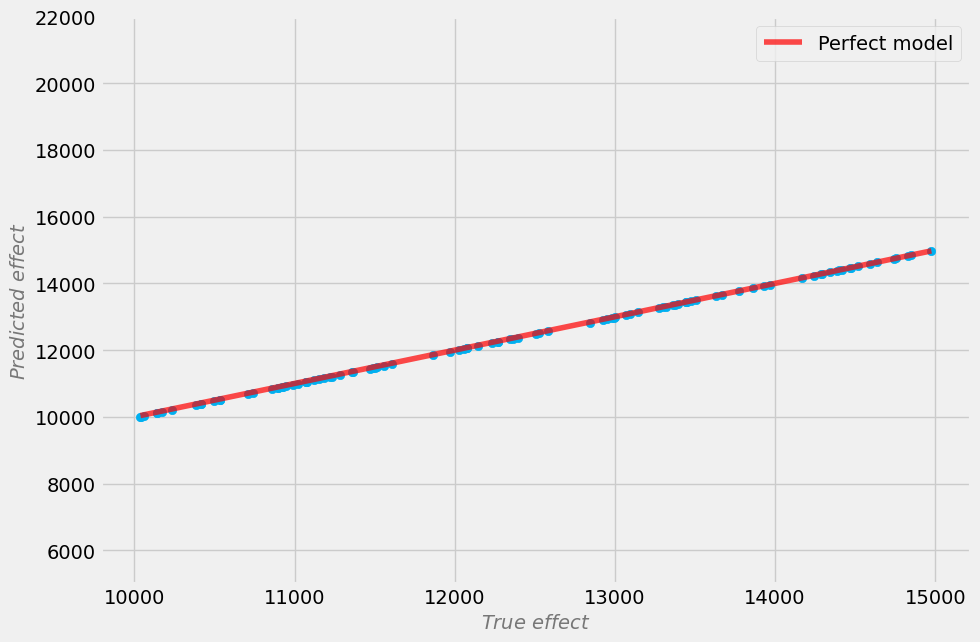

In [71]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

## Matching in the wild - simulation

### Probability of finding at least one match per row

In [72]:
results_per_dimension = {}

for d in range(2, 19):
    results = []
    
    N_SAMPLES = 1000
    DIM_X = d

    for i in tqdm(range(100)):

        X = np.random.binomial(n=1, p=.5, size=(N_SAMPLES, DIM_X))

        local_results = []

        for row in range(X.shape[0]):
            # Did we find at least 1 match for `row`?
            success = (np.where(np.where(X == X[row], 1, 0).sum(axis=1) == DIM_X, 1, 0).sum() - 1) > 0
            local_results.append(success)

        results.append(np.array(local_results).mean())
        
    results_per_dimension[d] = results

100%|█████████████████████████████████████████| 100/100 [00:12<00:00,  8.05it/s]


In [73]:
# Compute statistics
mean_p = pd.DataFrame(results_per_dimension).mean(axis=0).values
sd_p = pd.DataFrame(results_per_dimension).std(axis=0).values

invalid escape sequence '\m'
invalid escape sequence '\m'
invalid escape sequence '\m'


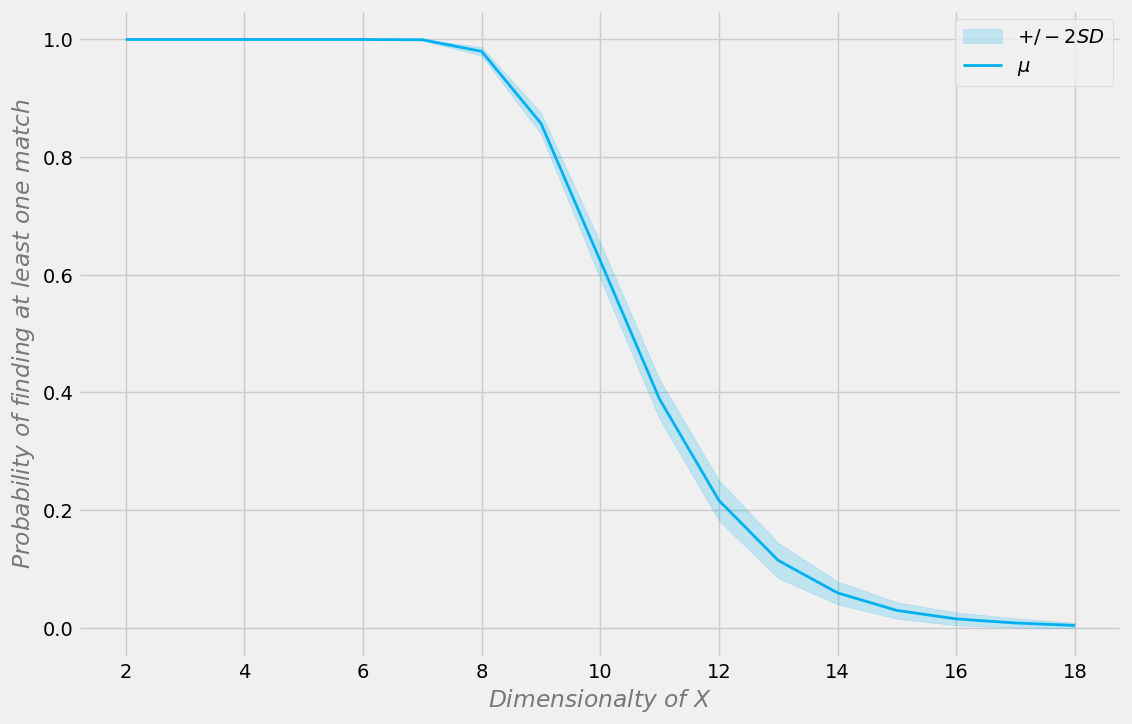

In [74]:
# Plot
plt.figure(figsize=(12, 8))
plt.fill_between(range(2, 19), mean_p - sd_p*2, mean_p + sd_p*2, color=COLORS[0], alpha=.2, label='$+/-2SD$')
plt.plot(range(2, 19), mean_p, color=COLORS[0], lw=2, label='$\mu$')
plt.legend()
plt.xlabel('$Dimensionalty \\ of \\ X$', alpha=.5)
plt.ylabel('$Probability \\ of \\ finding \\ at \\ least \\ one \\ match$', alpha=.5)
plt.show()